In [1]:
###############################################################################################
# Working prototype of Modulation Excitation Spectroscopy (MES) data processing protocol,     #
# written by Ryan Hagmann of the Hermans Research Group, UW-Madison, Mar. 2023.               #
###############################################################################################

In [2]:
"""Import necessary libraries."""

import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import scipy.fft    # Uses built in DFT algorithms from Scipy

In [3]:
"""Some useful functions, FFT/DFT replaced with Numpy implementation."""

def phase_angle(complex_value):
    """Finds am angle in the complex plane (ergo phase angle) for a given complex number."""
    angle = -np.angle(complex_value, deg = True)    # deg = False returns radians
    if angle < 0:
        angle += 360
    return angle

phi = 1    # Rotation angle in degrees

def rotate(complex_value, theta = (phi*np.pi/180)):
    """Rotate complex values counterclockwise in the imaginary plane by theta, preserving magnitude in output."""
    vector = np.array([[np.real(complex_value)], 
                       [np.imag(complex_value)]])    # Convert a + ib to vector [[a], [b]]
    operator = np.array([[np.cos(theta), -np.sin(theta)],    # Create rotation matrix
                         [np.sin(theta), np.cos(theta)]])
    new_vector = operator@vector    # Matrix multiplication for a rotated vector
    return new_vector[0][0].item()+new_vector[1][0].item()*1j

In [203]:
"""Reads data from data point table *.dpt files extracted from OPUS Rapid Scan protocol using pandas."""

path = r"C:\Users\ryanh\OneDrive - UW-Madison\Hermans_Group\ME-DRIFTS\combinedMES\10Cu68Ga22Zr_June15"    # Set working directory, called again to save processed data
file = r"\10Cu68Ga22Zr_June15.0.dpt"    # The specifc path extension of the file
file_path = path + file    # Combine for full path 
print(file_path)    # To ensure correct path

dpt = pd.read_csv(file_path, sep = ",", header = None, delim_whitespace = False)    # Import data, *.dpt files from OPUS are in csv format
dim = dpt.shape

print("Number of wavenumbers sampled over wavenumber range: " + str(dim[0]))    # Check dimensions of imported data to ensure it matches expected number of scans, etc.
print("Number of scans: " + str(dim[1] - 1))

# The data frame is imported like so: wavenumbers in the first column, scans over that spectrum in successive columns.
# Data is organized by wavenumber, each row is a subsequent scan

header = []
for wavenumber in dpt.iloc[0: , 0]:    # Round to nearest wavenumber for convenience
    header.append(str(round(wavenumber)))

data = dpt.T[1:]
data.columns = header
#data

C:\Users\ryanh\OneDrive - UW-Madison\Hermans_Group\ME-DRIFTS\combinedMES\10Cu68Ga22Zr_June15\10Cu68Ga22Zr_June15.0.dpt
Number of wavenumbers sampled over wavenumber range: 1244
Number of scans: 1200


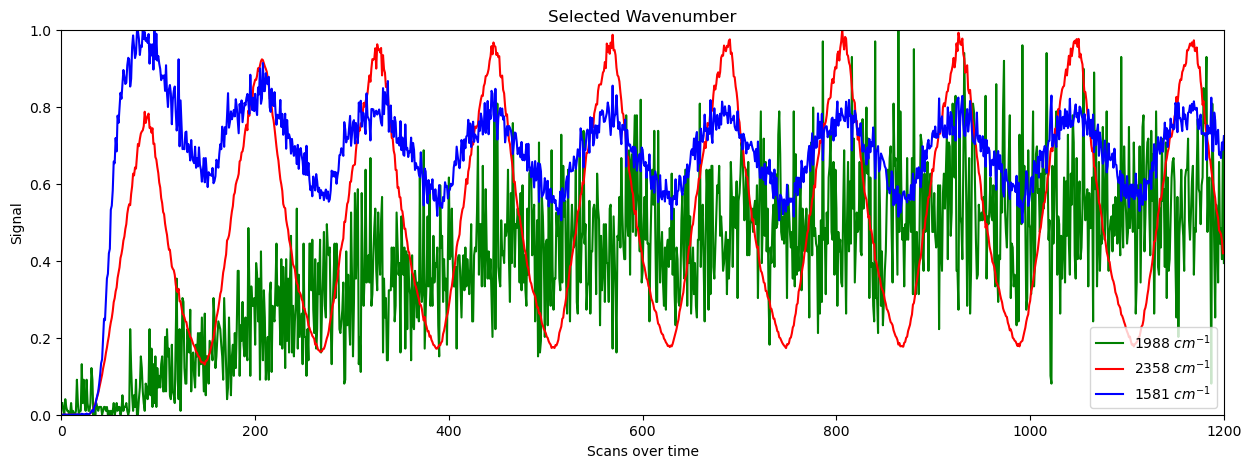

In [204]:
"""Show a few key frequencies over the course of the experiment."""

# Make a figure with an oscillating wavenumber

start = 0 # initial scan number 
end = dim[1] - 1 # final scan number

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(data["1988"]/np.max(data["1988"]), "g", label = "1988 $cm^{-1}$")    # Ga-H
ax.plot(data["2358"]/np.max(data["2358"]), "r", label = "2358 $cm^{-1}$")    # CO2
ax.plot(data["1581"]/np.max(data["1581"]), "b", label = "1581 $cm^{-1}$")    # Carbonates/formate?
#ax.plot(wavenumbers, dpt.iloc[:,dim[1]-1], "r", label="Last spectrum")
plt.xlabel("Scans over time")
plt.ylabel("Signal")
plt.title("Selected Wavenumber")
ax.set(
    xlim = (start, end),
    ylim = (0, 1)
    #xticks = np.arange(4000, 700, -500),
    )
ax.legend(loc="best")
plt.show()

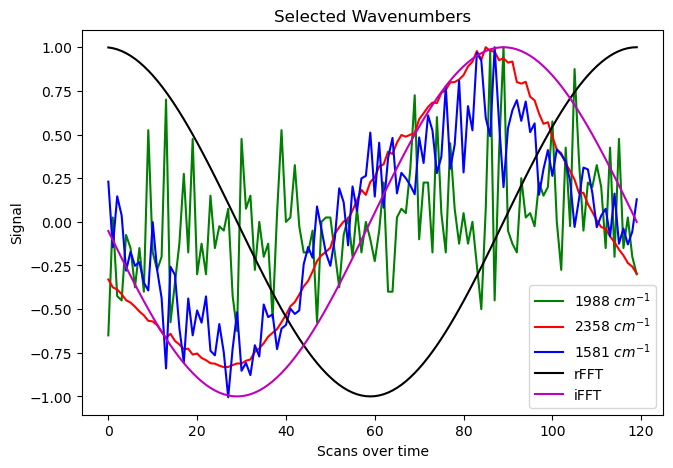

In [205]:
"""Average desired MES periods."""

n = 3 # Remove first n periods
N = 10 # Total number of periods
i = n

assert 0 < n < 10

spectrum = (n * 120)
avgd_period = data.iloc[spectrum: spectrum + 120, : ]

# Average remaining periods

while i < (N + 1):    # We use 10 periods, usually discard the first three
    avgd_period += data.iloc[spectrum: spectrum + 120, : ]
    i += 1
    
avgd_period /= (N - n)    # Normalize

"""Set mean intensity of each row (set of scans for each wavenumber) as 0.""" 

centered_period = avgd_period.sub(avgd_period.mean()).reset_index(drop = True)    # As in doc string
#centered_period = avgd_period.reset_index(drop = True)    # For testing, omits subtraction of mean
#centered_period    # Row index is scan number

"""Display averaged and centered period with normalized signals."""

fig, ax = plt.subplots(1, 1, figsize=(7.5, 5))
scans = np.arange(1, 121)
ax.plot(centered_period["1988"]/np.max(centered_period["1988"]), "g", label = "1988 $cm^{-1}$")
ax.plot(centered_period["2358"]/np.max(centered_period["2358"]), "r", label = "2358 $cm^{-1}$")
ax.plot(centered_period["1581"]/np.max(centered_period["1581"]), "b", label = "1581 $cm^{-1}$")
ax.plot(np.real(np.exp(-1j*2*np.pi*scans/120)), "k", label = "rFFT")
ax.plot(np.imag(np.exp(-1j*2*np.pi*scans/120)), "m", label = "iFFT")
plt.xlabel("Scans over time")
plt.ylabel("Signal")
plt.title("Selected Wavenumbers")
ax.set(
    #xlim = (start, end),
    #ylim = (0, 2)
    #xticks = np.arange(4000, 700, -500),
    )
ax.legend(loc="best")
plt.show()

In [206]:
centered_array = centered_period.T.to_numpy()
centered_array

array([[-8.67857143e-06,  6.84642857e-05,  1.70357143e-05, ...,
         1.70357143e-05, -8.67857143e-06,  4.17857143e-06],
       [-1.01785714e-05,  5.41071429e-05,  4.12500000e-05, ...,
         1.55357143e-05, -2.30357143e-05, -2.30357143e-05],
       [ 1.28571429e-06,  2.70000000e-05,  5.27142857e-05, ...,
        -1.15714286e-05, -2.44285714e-05, -2.44285714e-05],
       ...,
       [-5.42142857e-05, -7.99285714e-05, -4.52785714e-04, ...,
        -4.65642857e-04,  3.57857143e-05, -4.91357143e-04],
       [-3.35892857e-04, -1.43035714e-04, -3.10178571e-04, ...,
        -4.77321429e-04, -2.84464286e-04, -4.51607143e-04],
       [-4.23535714e-04, -1.66392857e-04,  2.96464286e-04, ...,
        -3.59250000e-04, -4.10678571e-04, -2.94964286e-04]])

In [207]:
"""Perform a discrete Fourier transform over the scans in each column/wavenumber."""

dft_array = scipy.fft.fft(centered_array)
dft = pd.DataFrame(dft_array.T, columns = centered_period.columns)
dft

,3996,3993,3991,3988,3986,3983,3980,3978,3975,3973,...,823,820,818,815,813,810,807,805,802,800
0,-1.219727e-18-0.000000e+00j,-1.490778e-18-0.000000e+00j,-1.416239e-18-0.000000e+00j,-1.639856e-18-0.000000e+00j,-9.080193e-19-0.000000e+00j,-1.829591e-18-0.000000e+00j,-1.453509e-18-0.000000e+00j,-1.490778e-18-0.000000e+00j,-1.626303e-18-0.000000e+00j,-4.336809e-19-0.000000e+00j,...,-8.239937e-18-0.000000e+00j,4.987330e-18-0.000000e+00j,8.673617e-19-0.000000e+00j,9.974660e-18-0.000000e+00j,-6.505213e-18-0.000000e+00j,4.336809e-18-0.000000e+00j,-8.673617e-18-0.000000e+00j,-2.949030e-17-0.000000e+00j,3.122502e-17-0.000000e+00j,2.602085e-18-0.000000e+00j
1,-2.998383e-04+2.481061e-04j,-2.610195e-04+2.965480e-05j,-1.189943e-04-2.538707e-04j,3.351044e-05-3.018945e-04j,1.097957e-04-2.999140e-04j,1.503889e-04-2.696059e-04j,2.610573e-04-2.868109e-04j,2.009553e-04-2.781805e-04j,1.040718e-04-1.828862e-04j,1.244538e-04-1.488519e-04j,...,-2.916534e-04-6.430849e-03j,-2.131916e-03-9.180829e-03j,-3.704031e-03-7.732646e-03j,-3.617552e-03-5.250894e-03j,-4.677932e-04-4.526127e-03j,4.284195e-03-4.198350e-03j,7.093001e-03-2.118280e-03j,6.775778e-03+8.551376e-04j,5.673542e-03+2.890829e-03j,4.354867e-03+3.758252e-03j
2,-2.626008e-04-2.871677e-04j,-3.938651e-04-2.666920e-04j,-4.318286e-04-2.239071e-04j,-4.760536e-04-2.749744e-04j,-3.569219e-04-2.937208e-04j,-1.541050e-04-2.725121e-04j,-8.117012e-05-3.644570e-04j,-1.517942e-04-4.327423e-04j,-3.172665e-04-5.243293e-04j,-3.601838e-04-4.736731e-04j,...,7.553765e-04+5.892364e-04j,3.056858e-03+1.278586e-03j,1.738999e-03+7.336925e-04j,-3.693938e-04-3.169551e-04j,-8.430234e-04-7.382917e-04j,-2.165287e-03-1.803347e-03j,-4.446794e-03-3.345688e-03j,-6.428457e-03-2.594093e-03j,-7.182214e-03-9.688494e-04j,-3.126012e-03-2.540017e-03j
3,1.360218e-04+4.410508e-05j,1.293418e-06+8.660505e-05j,-1.241594e-04+5.303873e-05j,-1.120462e-04-1.395451e-04j,-2.598050e-05-2.970115e-04j,1.320874e-04-2.691123e-04j,2.671832e-04-1.167127e-04j,1.551139e-04-5.114306e-05j,6.942120e-05+9.250376e-05j,4.540396e-05+1.462606e-04j,...,7.383423e-03+2.804351e-03j,6.066640e-03+8.155812e-04j,3.179987e-03-2.523967e-03j,6.035169e-04-6.657932e-03j,6.430404e-04-9.865397e-03j,1.518071e-03-1.208982e-02j,2.053066e-03-1.155429e-02j,4.050548e-03-6.499637e-03j,7.391850e-03-2.208108e-03j,8.408786e-03-2.900085e-03j
4,3.797267e-04+7.000015e-05j,4.044646e-04+1.428480e-04j,3.489904e-04+4.097195e-05j,2.692328e-04+3.870129e-05j,1.563665e-04+9.618019e-05j,2.025790e-05+1.701676e-04j,-9.861661e-05+2.203178e-04j,-1.436166e-04+1.390059e-04j,-1.283949e-04+3.670715e-05j,-2.011662e-04+9.672831e-07j,...,-2.658826e-04-3.072225e-03j,7.088726e-05-3.272955e-03j,2.390708e-03-2.117129e-03j,5.571601e-03-1.926642e-03j,5.828927e-03-6.064458e-03j,3.963215e-03-9.988415e-03j,4.492739e-03-9.063920e-03j,6.479079e-03-6.738074e-03j,5.213584e-03-4.974300e-03j,1.526449e-03-2.564324e-03j
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,-3.338966e-04+2.434584e-04j,-3.403188e-04+2.482211e-04j,-4.301651e-04+1.871868e-04j,-5.386696e-04-7.163601e-05j,-5.043816e-04-1.797809e-04j,-4.520379e-04-2.470592e-04j,-3.311607e-04-1.311537e-04j,-2.777641e-04-9.733364e-05j,-1.923809e-04+4.507848e-05j,-2.740905e-04+7.782650e-05j,...,-4.399169e-03-6.620308e-03j,-2.471104e-03-5.867055e-03j,-2.525834e-04-2.501451e-03j,1.337746e-03-1.037163e-05j,1.211748e-03-3.194311e-05j,5.433160e-04-1.838287e-03j,1.891189e-04-3.368810e-03j,-2.004237e-03-2.640110e-03j,-4.419449e-03+1.932917e-03j,-5.176571e-03+7.030423e-03j
116,3.797267e-04-7.000015e-05j,4.044646e-04-1.428480e-04j,3.489904e-04-4.097195e-05j,2.692328e-04-3.870129e-05j,1.563665e-04-9.618019e-05j,2.025790e-05-1.701676e-04j,-9.861661e-05-2.203178e-04j,-1.436166e-04-1.390059e-04j,-1.283949e-04-3.670715e-05j,-2.011662e-04-9.672831e-07j,...,-2.658826e-04+3.072225e-03j,7.088726e-05+3.272955e-03j,2.390708e-03+2.117129e-03j,5.571601e-03+1.926642e-03j,5.828927e-03+6.064458e-03j,3.963215e-03+9.988415e-03j,4.492739e-03+9.063920e-03j,6.47

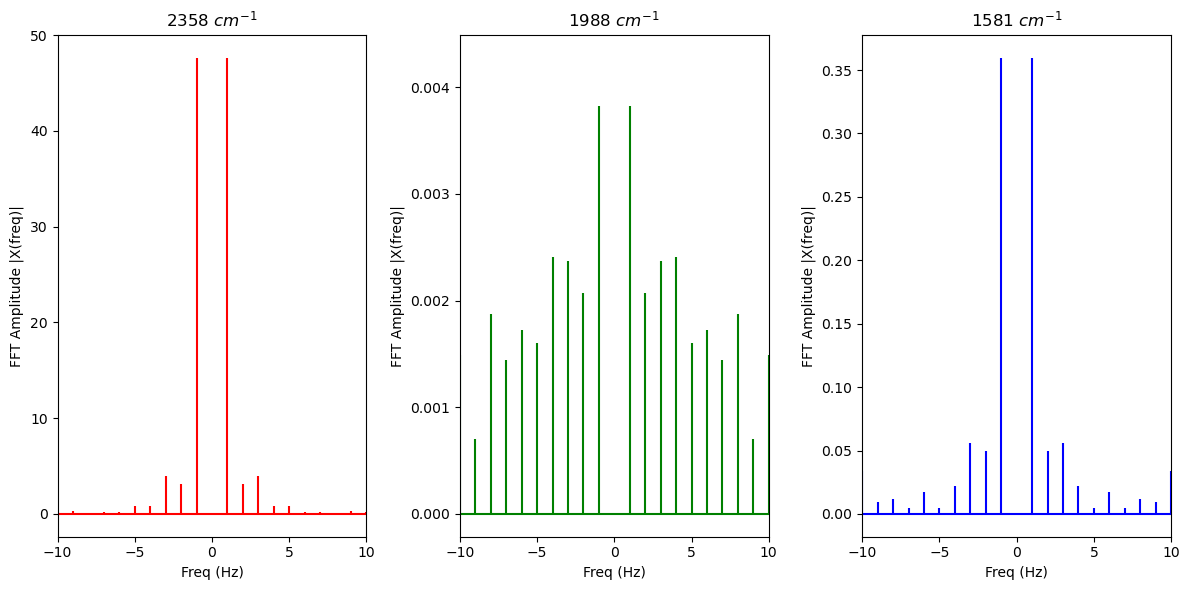

In [208]:
"""Look at frequencies to ascertain waveform."""

freq_range = 10

plt.figure(figsize = (12, 6))

plt.subplot(131)
plt.stem(np.arange(-len(dft["2358"])/2, len(dft["2358"])/2),
         np.abs(scipy.fft.fftshift(dft["2358"])), 
         linefmt='r',
         markerfmt=" ", 
         basefmt="-r")
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.xlim(-freq_range, freq_range)
plt.title("2358 $cm^{-1}$")

plt.subplot(132)
plt.stem(np.arange(-len(dft["1988"])/2, len(dft["1988"])/2),
         np.abs(scipy.fft.fftshift(dft["1988"])), 
         linefmt='g',
         markerfmt=" ", 
         basefmt="-g")
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.xlim(-freq_range, freq_range)
plt.title("1988 $cm^{-1}$")

plt.subplot(133)
plt.stem(np.arange(-len(dft["1581"])/2, len(dft["1581"])/2),
         np.abs(scipy.fft.fftshift(dft["1581"])), 
         linefmt='b',
         markerfmt=" ", 
         basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.xlim(-freq_range, freq_range)
plt.title("1581 $cm^{-1}$")

# plt.subplot(132)
# plt.plot(freqx, np.abs(X), 'r')
# plt.plot(freqy, np.abs(Y), 'b')
# plt.xlabel('Freq (Hz)')
# plt.ylabel('FFT Amplitude |X(freq)|')
# plt.xlim(0, 20)

# plt.subplot(133)
# plt.plot(tx, np.fft.ifft(X), 'r')
# plt.plot(ty, np.fft.ifft(Y), 'b')
# plt.xlabel('Time (s)')
# plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

An excerpt from:

Srinivasan, P. D.; Patil, B. S.; Zhu, H.; Bravo-Suárez, J. J. Application of Modulation Excitation-Phase Sensitive Detection-DRIFTS for in Situ 
/Operando Characterization of Heterogeneous Catalysts. React. Chem. Eng. 2019, 4 (5), 862–883. https://doi.org/10.1039/C9RE00011A.


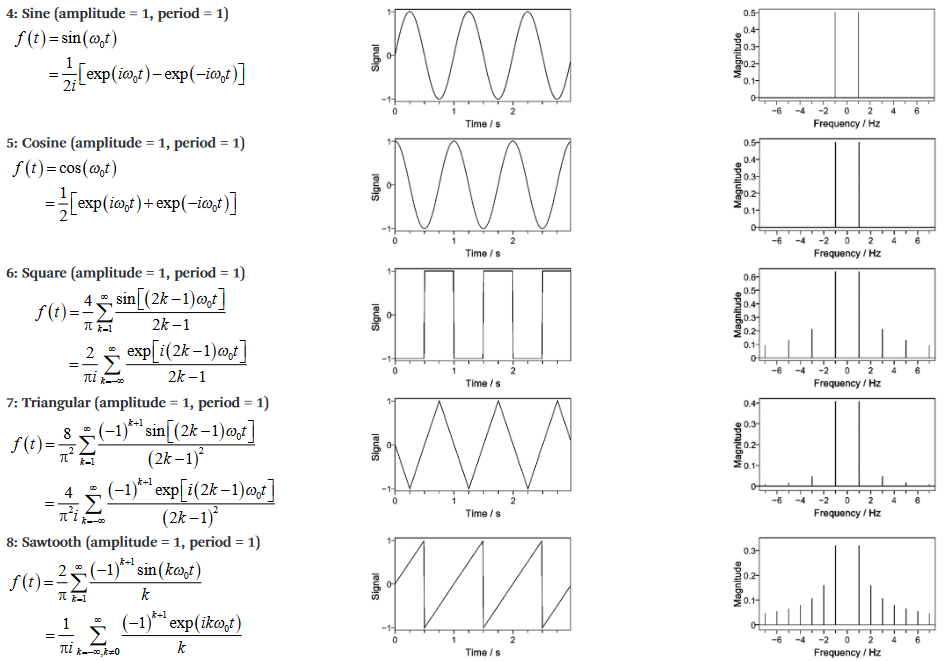

In [209]:
"""Revert column titles to experimental wavenumbers."""

dft.columns = dpt.iloc[0: , 0]
dft.head()

,3995.82599,3993.25467,3990.68336,3988.11204,3985.54072,3982.96941,3980.39809,3977.82677,3975.25546,3972.68414,...,822.82131,820.24999,817.67868,815.10736,812.53604,809.96473,807.39341,804.82209,802.25078,799.67946
0,-1.219727e-18-0.000000e+00j,-1.490778e-18-0.000000e+00j,-1.416239e-18-0.000000e+00j,-1.639856e-18-0.000000e+00j,-9.080193e-19-0.000000e+00j,-1.829591e-18-0.000000e+00j,-1.453509e-18-0.000000e+00j,-1.490778e-18-0.000000e+00j,-1.626303e-18-0.000000e+00j,-4.336809e-19-0.000000e+00j,...,-8.239937e-18-0.000000e+00j,4.987330e-18-0.000000e+00j,8.673617e-19-0.000000e+00j,9.974660e-18-0.000000e+00j,-6.505213e-18-0.000000e+00j,4.336809e-18-0.000000e+00j,-8.673617e-18-0.000000e+00j,-2.949030e-17-0.000000e+00j,3.122502e-17-0.000000e+00j,2.602085e-18-0.000000e+00j
1,-2.998383e-04+2.481061e-04j,-2.610195e-04+2.965480e-05j,-1.189943e-04-2.538707e-04j,3.351044e-05-3.018945e-04j,1.097957e-04-2.999140e-04j,1.503889e-04-2.696059e-04j,2.610573e-04-2.868109e-04j,2.009553e-04-2.781805e-04j,1.040718e-04-1.828862e-04j,1.244538e-04-1.488519e-04j,...,-2.916534e-04-6.430849e-03j,-2.131916e-03-9.180829e-03j,-3.704031e-03-7.732646e-03j,-3.617552e-03-5.250894e-03j,-4.677932e-04-4.526127e-03j,4.284195e-03-4.198350e-03j,7.093001e-03-2.118280e-03j,6.775778e-03+8.551376e-04j,5.673542e-03+2.890829e-03j,4.354867e-03+3.758252e-03j
2,-2.626008e-04-2.871677e-04j,-3.938651e-04-2.666920e-04j,-4.318286e-04-2.239071e-04j,-4.760536e-04-2.749744e-04j,-3.569219e-04-2.937208e-04j,-1.541050e-04-2.725121e-04j,-8.117012e-05-3.644570e-04j,-1.517942e-04-4.327423e-04j,-3.172665e-04-5.243293e-04j,-3.601838e-04-4.736731e-04j,...,7.553765e-04+5.892364e-04j,3.056858e-03+1.278586e-03j,1.738999e-03+7.336925e-04j,-3.693938e-04-3.169551e-04j,-8.430234e-04-7.382917e-04j,-2.165287e-03-1.803347e-03j,-4.446794e-03-3.345688e-03j,-6.428457e-03-2.594093e-03j,-7.182214e-03-9.688494e-04j,-3.126012e-03-2.540017e-03j
3,1.360218e-04+4.410508e-05j,1.293418e-06+8.660505e-05j,-1.241594e-04+5.303873e-05j,-1.120462e-04-1.395451e-04j,-2.598050e-05-2.970115e-04j,1.320874e-04-2.691123e-04j,2.671832e-04-1.167127e-04j,1.551139e-04-5.114306e-05j,6.942120e-05+9.250376e-05j,4.540396e-05+1.462606e-04j,...,7.383423e-03+2.804351e-03j,6.066640e-03+8.155812e-04j,3.179987e-03-2.523967e-03j,6.035169e-04-6.657932e-03j,6.430404e-04-9.865397e-03j,1.518071e-03-1.208982e-02j,2.053066e-03-1.155429e-02j,4.050548e-03-6.499637e-03j,7.391850e-03-2.208108e-03j,8.408786e-03-2.900085e-03j
4,3.797267e-04+7.000015e-05j,4.044646e-04+1.428480e-04j,3.489904e-04+4.097195e-05j,2.692328e-04+3.870129e-05j,1.563665e-04+9.618019e-05j,2.025790e-05+1.701676e-04j,-9.861661e-05+2.203178e-04j,-1.436166e-04+1.390059e-04j,-1.283949e-04+3.670715e-05j,-2.011662e-04+9.672831e-07j,...,-2.658826e-04-3.072225e-03j,7.088726e-05-3.272955e-03j,2.390708e-03-2.117129e-03j,5.571601e-03-1.926642e-03j,5.828927e-03-6.064458e-03j,3.963215e-03-9.988415e-03j,4.492739e-03-9.063920e-03j,6.479079e-03-6.738074e-03j,5.213584e-03-4.974300e-03j,1.526449e-03-2.564324e-03j


In [210]:
"""Find peak phase angles for each wavenumber."""

angles = dft.applymap(phase_angle)    # Returns all phase angles in radians
angles

,3995.82599,3993.25467,3990.68336,3988.11204,3985.54072,3982.96941,3980.39809,3977.82677,3975.25546,3972.68414,...,822.82131,820.24999,817.67868,815.10736,812.53604,809.96473,807.39341,804.82209,802.25078,799.67946
0,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,...,180.000000,0.000000,0.000000,0.000000,180.000000,0.000000,180.000000,180.000000,0.000000,0.000000
1,219.606615,186.481663,115.113429,83.666069,69.892800,60.846770,47.691322,54.155965,60.357863,50.101297,...,92.596712,103.073181,115.594984,124.564520,95.900795,44.420174,16.627920,352.807010,332.999881,319.205791
2,132.441389,145.897478,152.592847,149.988742,140.548104,119.488062,102.555722,109.329482,121.177723,127.249567,...,322.043751,337.302006,337.124865,139.369051,138.789210,140.210971,143.042856,158.024310,172.317424,140.904685
3,342.034708,270.855630,203.131322,128.762354,94.999112,63.856973,23.596985,18.248061,306.887091,287.246008,...,339.202365,352.343232,38.439152,84.820505,86.270657,82.843052,79.924358,58.069001,16.632042,19.028674
4,349.555156,340.547896,353.304049,351.819963,328.404556,276.788927,245.886199,224.065366,195.954846,180.275498,...,94.946282,88.759254,41.527009,19.075219,46.134509,68.357754,63.633631,46.122589,43.654535,59.236198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,216.097407,216.106197,203.516321,172.424859,160.381987,151.341398,158.394330,160.688601,193.187565,195.851604,...,123.603886,112.840001,95.765884,0.444209,1.510035,73.534662,86.786892,127.203920,203.622937,233.635409
116,10.444844,19.452104,6.695951,8.180037,31.595444,83.211073,114.113801,135.934634,164.045154,179.724502,...,265.053718,271.240746,318.472991,340.924781,313.865491,291.642246,296.366369,313.877411,316.345465,300.763802
117,17.965292,89.144370,156.868678,231.237646,265.000888,296.143027,336.403015,341.751939,53.112909,72.753992,...,20.797635,7.656768,321.560848,275.179495,273.729343,277.156948,280.075642,301.930999,343.367958,340.971326
118,227.558611,214.102522,207.407153,210.011258,219.451896,240.511938,257.444278,250.670518,238.822277,232.750433,...,37.956249,22.697994,22.875135,220.630949,221.210790,219.789029,216.957144,201.975690,187.682576,219.095315


In [211]:
"""Rotate complex values for each wavenumber."""

rotated = pd.DataFrame(dft.applymap(rotate))
rotated.applymap(phase_angle)    # Ensure rotation worked

,3995.82599,3993.25467,3990.68336,3988.11204,3985.54072,3982.96941,3980.39809,3977.82677,3975.25546,3972.68414,...,822.82131,820.24999,817.67868,815.10736,812.53604,809.96473,807.39341,804.82209,802.25078,799.67946
0,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,...,179.000000,359.000000,359.000000,359.000000,179.000000,359.000000,179.000000,179.000000,359.000000,359.000000
1,218.606615,185.481663,114.113429,82.666069,68.892800,59.846770,46.691322,53.155965,59.357863,49.101297,...,91.596712,102.073181,114.594984,123.564520,94.900795,43.420174,15.627920,351.807010,331.999881,318.205791
2,131.441389,144.897478,151.592847,148.988742,139.548104,118.488062,101.555722,108.329482,120.177723,126.249567,...,321.043751,336.302006,336.124865,138.369051,137.789210,139.210971,142.042856,157.024310,171.317424,139.904685
3,341.034708,269.855630,202.131322,127.762354,93.999112,62.856973,22.596985,17.248061,305.887091,286.246008,...,338.202365,351.343232,37.439152,83.820505,85.270657,81.843052,78.924358,57.069001,15.632042,18.028674
4,348.555156,339.547896,352.304049,350.819963,327.404556,275.788927,244.886199,223.065366,194.954846,179.275498,...,93.946282,87.759254,40.527009,18.075219,45.134509,67.357754,62.633631,45.122589,42.654535,58.236198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,215.097407,215.106197,202.516321,171.424859,159.381987,150.341398,157.394330,159.688601,192.187565,194.851604,...,122.603886,111.840001,94.765884,359.444209,0.510035,72.534662,85.786892,126.203920,202.622937,232.635409
116,9.444844,18.452104,5.695951,7.180037,30.595444,82.211073,113.113801,134.934634,163.045154,178.724502,...,264.053718,270.240746,317.472991,339.924781,312.865491,290.642246,295.366369,312.877411,315.345465,299.763802
117,16.965292,88.144370,155.868678,230.237646,264.000888,295.143027,335.403015,340.751939,52.112909,71.753992,...,19.797635,6.656768,320.560848,274.179495,272.729343,276.156948,279.075642,300.930999,342.367958,339.971326
118,226.558611,213.102522,206.407153,209.011258,218.451896,239.511938,256.444278,249.670518,237.822277,231.750433,...,36.956249,21.697994,21.875135,219.630949,220.210790,218.789029,215.957144,200.975690,186.682576,218.095315


In [212]:
"""Create a dataframe of spectra for all specified phase angles."""

i = 1 # Index for iteration
phase_angle_array = pd.DataFrame(dft.iloc[1, : ]).T.to_numpy()    # Initiate numpy array

while i < 360:
    new_row = []
    for item in phase_angle_array[-1]:
        new_row.append(rotate(item))
    new = np.vstack((phase_angle_array, new_row))
    phase_angle_array = new
    i += 1
    
all_phase_angles = pd.DataFrame(data = phase_angle_array, columns = dft.columns)

In [213]:
all_phase_angles.head()

,3995.82599,3993.25467,3990.68336,3988.11204,3985.54072,3982.96941,3980.39809,3977.82677,3975.25546,3972.68414,...,822.82131,820.24999,817.67868,815.10736,812.53604,809.96473,807.39341,804.82209,802.25078,799.67946
0,-0.000300+0.000248j,-0.000261+0.000030j,-0.000119-0.000254j,0.000034-0.000302j,0.000110-0.000300j,0.000150-0.000270j,0.000261-0.000287j,0.000201-0.000278j,0.000104-0.000183j,0.000124-0.000149j,...,-0.000292-0.006431j,-0.002132-0.009181j,-0.003704-0.007733j,-0.003618-0.005251j,-0.000468-0.004526j,0.004284-0.004198j,0.007093-0.002118j,0.006776+0.000855j,0.005674+0.002891j,0.004355+0.003758j
1,-0.000304+0.000243j,-0.000261+0.000025j,-0.000115-0.000256j,0.000039-0.000301j,0.000115-0.000298j,0.000155-0.000267j,0.000266-0.000282j,0.000206-0.000275j,0.000107-0.000181j,0.000127-0.000147j,...,-0.000179-0.006435j,-0.001971-0.009217j,-0.003569-0.007796j,-0.003525-0.005313j,-0.000389-0.004534j,0.004357-0.004123j,0.007129-0.001994j,0.006760+0.000973j,0.005622+0.002989j,0.004289+0.003834j
2,-0.000308+0.000237j,-0.000262+0.000021j,-0.000110-0.000258j,0.000044-0.000301j,0.000120-0.000296j,0.000160-0.000264j,0.000271-0.000278j,0.000211-0.000271j,0.000110-0.000179j,0.000130-0.000144j,...,-0.000067-0.006437j,-0.001810-0.009250j,-0.003432-0.007857j,-0.003432-0.005374j,-0.000310-0.004540j,0.004428-0.004046j,0.007163-0.001869j,0.006742+0.001091j,0.005569+0.003087j,0.004221+0.003908j
3,-0.000312+0.000232j,-0.000262+0.000016j,-0.000106-0.000260j,0.000049-0.000300j,0.000125-0.000294j,0.000164-0.000261j,0.000276-0.000273j,0.000215-0.000267j,0.000114-0.000177j,0.000132-0.000142j,...,0.000045-0.006437j,-0.001649-0.009280j,-0.003294-0.007916j,-0.003338-0.005433j,-0.000230-0.004544j,0.004498-0.003968j,0.007194-0.001744j,0.006722+0.001209j,0.005514+0.003184j,0.004152+0.003981j
4,-0.000316+0.000227j,-0.000262+0.000011j,-0.000101-0.000262j,0.000054-0.000299j,0.000130-0.000292j,0.000169-0.000258j,0.000280-0.000268j,0.000220-0.000263j,0.000117-0.000175j,0.000135-0.000140j,...,0.000158-0.006436j,-0.001486-0.009307j,-0.003156-0.007972j,-0.003242-0.005490j,-0.000151-0.004548j,0.004567-0.003889j,0.007223-0.001618j,0.006700+0.001326j,0.005458+0.003280j,0.004082+0.004053j


In [214]:
"""Revert column titles to experimental wavenumbers."""

angles.columns = dpt.iloc[0: , 0]
angles

,3995.82599,3993.25467,3990.68336,3988.11204,3985.54072,3982.96941,3980.39809,3977.82677,3975.25546,3972.68414,...,822.82131,820.24999,817.67868,815.10736,812.53604,809.96473,807.39341,804.82209,802.25078,799.67946
0,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,...,180.000000,0.000000,0.000000,0.000000,180.000000,0.000000,180.000000,180.000000,0.000000,0.000000
1,219.606615,186.481663,115.113429,83.666069,69.892800,60.846770,47.691322,54.155965,60.357863,50.101297,...,92.596712,103.073181,115.594984,124.564520,95.900795,44.420174,16.627920,352.807010,332.999881,319.205791
2,132.441389,145.897478,152.592847,149.988742,140.548104,119.488062,102.555722,109.329482,121.177723,127.249567,...,322.043751,337.302006,337.124865,139.369051,138.789210,140.210971,143.042856,158.024310,172.317424,140.904685
3,342.034708,270.855630,203.131322,128.762354,94.999112,63.856973,23.596985,18.248061,306.887091,287.246008,...,339.202365,352.343232,38.439152,84.820505,86.270657,82.843052,79.924358,58.069001,16.632042,19.028674
4,349.555156,340.547896,353.304049,351.819963,328.404556,276.788927,245.886199,224.065366,195.954846,180.275498,...,94.946282,88.759254,41.527009,19.075219,46.134509,68.357754,63.633631,46.122589,43.654535,59.236198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,216.097407,216.106197,203.516321,172.424859,160.381987,151.341398,158.394330,160.688601,193.187565,195.851604,...,123.603886,112.840001,95.765884,0.444209,1.510035,73.534662,86.786892,127.203920,203.622937,233.635409
116,10.444844,19.452104,6.695951,8.180037,31.595444,83.211073,114.113801,135.934634,164.045154,179.724502,...,265.053718,271.240746,318.472991,340.924781,313.865491,291.642246,296.366369,313.877411,316.345465,300.763802
117,17.965292,89.144370,156.868678,231.237646,265.000888,296.143027,336.403015,341.751939,53.112909,72.753992,...,20.797635,7.656768,321.560848,275.179495,273.729343,277.156948,280.075642,301.930999,343.367958,340.971326
118,227.558611,214.102522,207.407153,210.011258,219.451896,240.511938,257.444278,250.670518,238.822277,232.750433,...,37.956249,22.697994,22.875135,220.630949,221.210790,219.789029,216.957144,201.975690,187.682576,219.095315


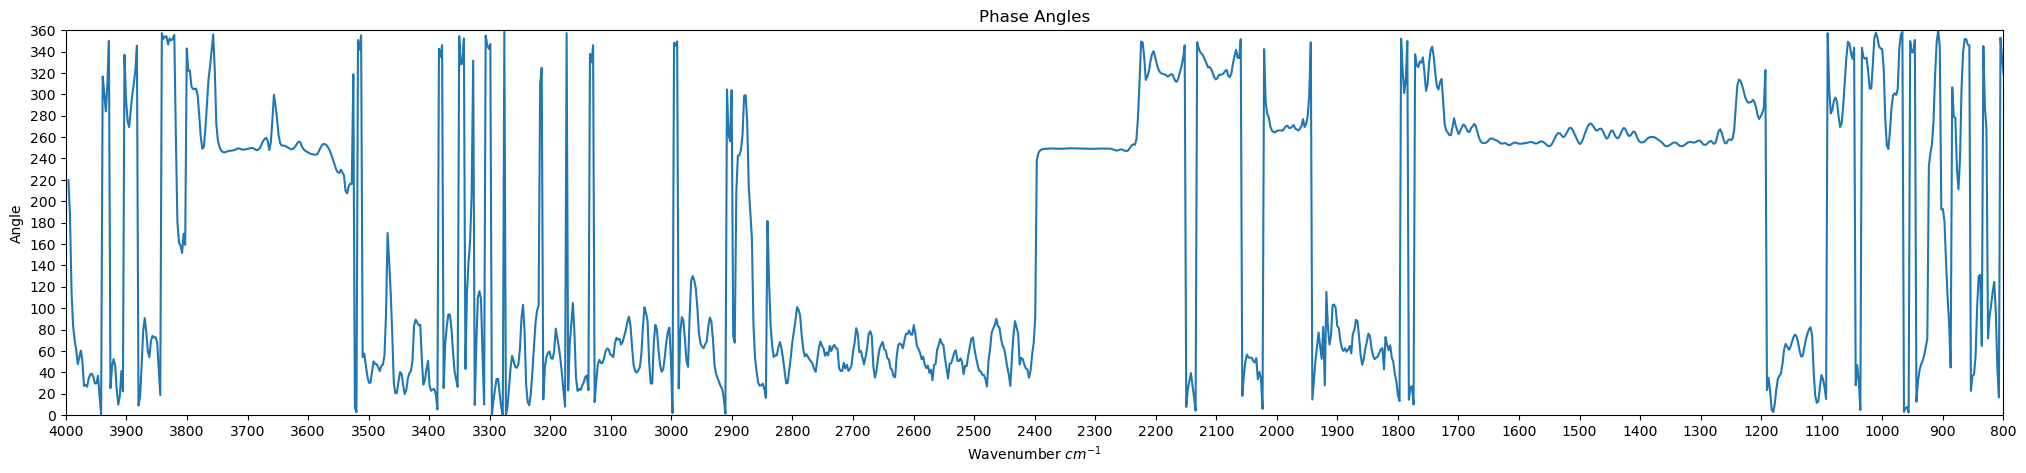

In [215]:
"""Phase angle by wavenumber plot."""

fig, ax = plt.subplots(1, 1, figsize=(25, 5))
plt.plot(angles.columns, angles.iloc[1, :])
ax.set(
    xlim = (4000, 800),
    ylim = (0, 360),
    xticks = np.arange(4000, 750, -100),
    yticks = np.arange(0, 370, 20)
)
plt.title("Phase Angles")
plt.xlabel("Wavenumber $cm^{-1}$")
plt.ylabel("Angle")
plt.show()

In [216]:
# fig.savefig(path + "\\phase_angles.jpg")

In [217]:
"""Take the real components."""

real_components = all_phase_angles.applymap(np.real)
real_components #*= 10**15

,3995.82599,3993.25467,3990.68336,3988.11204,3985.54072,3982.96941,3980.39809,3977.82677,3975.25546,3972.68414,...,822.82131,820.24999,817.67868,815.10736,812.53604,809.96473,807.39341,804.82209,802.25078,799.67946
0,-0.000300,-0.000261,-0.000119,0.000034,0.000110,0.000150,0.000261,0.000201,0.000104,0.000124,...,-0.000292,-0.002132,-0.003704,-0.003618,-0.000468,0.004284,0.007093,0.006776,0.005674,0.004355
1,-0.000304,-0.000261,-0.000115,0.000039,0.000115,0.000155,0.000266,0.000206,0.000107,0.000127,...,-0.000179,-0.001971,-0.003569,-0.003525,-0.000389,0.004357,0.007129,0.006760,0.005622,0.004289
2,-0.000308,-0.000262,-0.000110,0.000044,0.000120,0.000160,0.000271,0.000211,0.000110,0.000130,...,-0.000067,-0.001810,-0.003432,-0.003432,-0.000310,0.004428,0.007163,0.006742,0.005569,0.004221
3,-0.000312,-0.000262,-0.000106,0.000049,0.000125,0.000164,0.000276,0.000215,0.000114,0.000132,...,0.000045,-0.001649,-0.003294,-0.003338,-0.000230,0.004498,0.007194,0.006722,0.005514,0.004152
4,-0.000316,-0.000262,-0.000101,0.000054,0.000130,0.000169,0.000280,0.000220,0.000117,0.000135,...,0.000158,-0.001486,-0.003156,-0.003242,-0.000151,0.004567,0.007223,0.006700,0.005458,0.004082
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,-0.000277,-0.000257,-0.000141,0.000007,0.000083,0.000126,0.000235,0.000176,0.000088,0.000111,...,-0.000851,-0.002924,-0.004364,-0.004061,-0.000860,0.003902,0.006881,0.006825,0.005904,0.004666
356,-0.000282,-0.000258,-0.000136,0.000012,0.000089,0.000131,0.000240,0.000181,0.000091,0.000114,...,-0.000740,-0.002767,-0.004234,-0.003975,-0.000782,0.003981,0.006928,0.006819,0.005861,0.004606
357,-0.000286,-0.000259,-0.000132,0.000018,0.000094,0.000136,0.000246,0.000186,0.000094,0.000116,...,-0.000628,-0.002609,-0.004104,-0.003887,-0.000704,0.004059,0.006972,0.006811,0.005817,0.004546
358,-0.000291,-0.000260,-0.000128,0.000023,0.000099,0.000141,0.000251,0.000191,0.000098,0.000119,...,-0.000516,-0.002451,-0.003972,-0.003799,-0.000625,0.004135,0.007015,0.006801,0.005771,0.004483


In [218]:
"""Revert column titles to experimental wavenumbers."""

real_components.columns = dpt.iloc[0: , 0]
real_components

,3995.82599,3993.25467,3990.68336,3988.11204,3985.54072,3982.96941,3980.39809,3977.82677,3975.25546,3972.68414,...,822.82131,820.24999,817.67868,815.10736,812.53604,809.96473,807.39341,804.82209,802.25078,799.67946
0,-0.000300,-0.000261,-0.000119,0.000034,0.000110,0.000150,0.000261,0.000201,0.000104,0.000124,...,-0.000292,-0.002132,-0.003704,-0.003618,-0.000468,0.004284,0.007093,0.006776,0.005674,0.004355
1,-0.000304,-0.000261,-0.000115,0.000039,0.000115,0.000155,0.000266,0.000206,0.000107,0.000127,...,-0.000179,-0.001971,-0.003569,-0.003525,-0.000389,0.004357,0.007129,0.006760,0.005622,0.004289
2,-0.000308,-0.000262,-0.000110,0.000044,0.000120,0.000160,0.000271,0.000211,0.000110,0.000130,...,-0.000067,-0.001810,-0.003432,-0.003432,-0.000310,0.004428,0.007163,0.006742,0.005569,0.004221
3,-0.000312,-0.000262,-0.000106,0.000049,0.000125,0.000164,0.000276,0.000215,0.000114,0.000132,...,0.000045,-0.001649,-0.003294,-0.003338,-0.000230,0.004498,0.007194,0.006722,0.005514,0.004152
4,-0.000316,-0.000262,-0.000101,0.000054,0.000130,0.000169,0.000280,0.000220,0.000117,0.000135,...,0.000158,-0.001486,-0.003156,-0.003242,-0.000151,0.004567,0.007223,0.006700,0.005458,0.004082
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,-0.000277,-0.000257,-0.000141,0.000007,0.000083,0.000126,0.000235,0.000176,0.000088,0.000111,...,-0.000851,-0.002924,-0.004364,-0.004061,-0.000860,0.003902,0.006881,0.006825,0.005904,0.004666
356,-0.000282,-0.000258,-0.000136,0.000012,0.000089,0.000131,0.000240,0.000181,0.000091,0.000114,...,-0.000740,-0.002767,-0.004234,-0.003975,-0.000782,0.003981,0.006928,0.006819,0.005861,0.004606
357,-0.000286,-0.000259,-0.000132,0.000018,0.000094,0.000136,0.000246,0.000186,0.000094,0.000116,...,-0.000628,-0.002609,-0.004104,-0.003887,-0.000704,0.004059,0.006972,0.006811,0.005817,0.004546
358,-0.000291,-0.000260,-0.000128,0.000023,0.000099,0.000141,0.000251,0.000191,0.000098,0.000119,...,-0.000516,-0.002451,-0.003972,-0.003799,-0.000625,0.004135,0.007015,0.006801,0.005771,0.004483


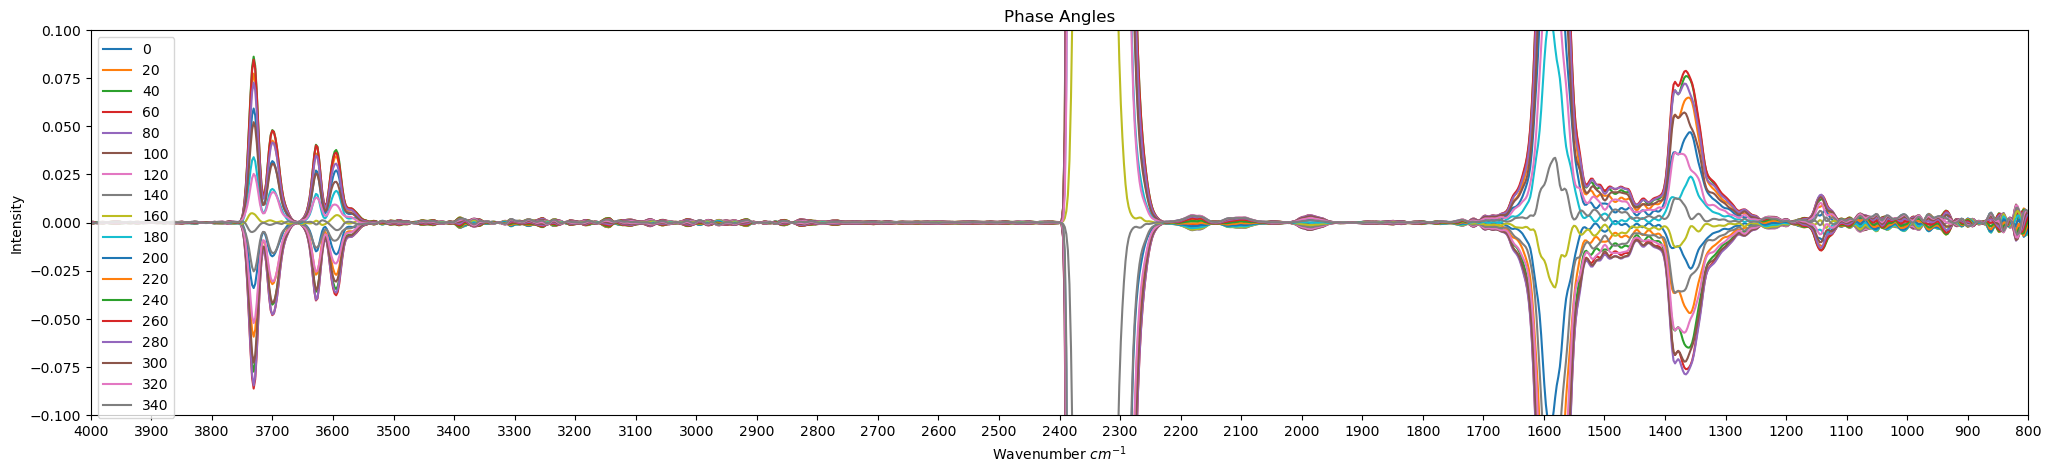

In [219]:
"""Plot real components."""

phase_angles = np.arange(0, 360, 20)    # Which angles to plot
# phase_angles = [70, 160, 250, 270, 315, 340]

y_scale = .1



fig, ax = plt.subplots(1, 1, figsize=(25, 5))
for angle in phase_angles:    # No more copying line by line to add angles
    ax.plot(real_components.columns, real_components.iloc[angle, :], label = str(angle))
ax.set(
    xlim = (4000, 800),
    ylim = (-y_scale, y_scale),
    xticks = np.arange(4000, 750, -100),
    #yticks = np.arange(0, 370, 20)
)
plt.title("Phase Angles")
plt.xlabel("Wavenumber $cm^{-1}$")
plt.ylabel("Intensity")
plt.legend(loc = "upper left")
plt.show()

In [220]:
# fig.savefig(path + "\\spectrum_by_phase_angles2.jpg")

In [221]:
"""Save all numerical results."""

# Fourier transformed output and phase angles

output_and_angles = pd.concat([dft.iloc[1, : ], angles.iloc[1, : ]], axis = 1)
output_and_angles.columns = ["Discrete Fourier Transform", "Phase Angle"]
save_to_excel_name = path + "\\FT_output_and_angles.xlsx"
output_and_angles.to_excel(save_to_excel_name)

#Save real components by phase angle data."""

save_to_excel_name = path + "\\real_components_by_phase_angle.xlsx"
real_components.to_excel(save_to_excel_name)

In [222]:
output_and_angles = pd.concat([dft.iloc[1, : ], angles.iloc[1, : ]], axis = 1)
output_and_angles.columns = ["Discrete Fourier Transform", "Phase Angle"]
output_and_angles

,Discrete Fourier Transform,Phase Angle
0,,
3995.82599,-0.000300+0.000248j,219.606615
3993.25467,-0.000261+0.000030j,186.481663
3990.68336,-0.000119-0.000254j,115.113429
3988.11204,0.000034-0.000302j,83.666069
3985.54072,0.000110-0.000300j,69.892800
...,...,...
809.96473,0.004284-0.004198j,44.420174
807.39341,0.007093-0.002118j,16.627920
804.82209,0.006776+0.000855j,352.807010


In [223]:
"""Filter discrete Fourier transform over the scans in each column/wavenumber, remove undesired frequencies."""

evens = np.arange(0, 120, 2)
filtered_dft = dft.copy()

for row in evens:    # Remove even frequencies 
    filtered_dft.iloc[row] = 0
    
filtered_dft.iloc[4:] = 0    # Remove high frequencies 
filtered_dft.head(10)

,3995.82599,3993.25467,3990.68336,3988.11204,3985.54072,3982.96941,3980.39809,3977.82677,3975.25546,3972.68414,...,822.82131,820.24999,817.67868,815.10736,812.53604,809.96473,807.39341,804.82209,802.25078,799.67946
0,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,...,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j
1,-0.000300+0.000248j,-0.000261+0.000030j,-0.000119-0.000254j,0.000034-0.000302j,0.000110-0.000300j,0.000150-0.000270j,0.000261-0.000287j,0.000201-0.000278j,0.000104-0.000183j,0.000124-0.000149j,...,-0.000292-0.006431j,-0.002132-0.009181j,-0.003704-0.007733j,-0.003618-0.005251j,-0.000468-0.004526j,0.004284-0.004198j,0.007093-0.002118j,0.006776+0.000855j,0.005674+0.002891j,0.004355+0.003758j
2,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,...,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j
3,0.000136+0.000044j,0.000001+0.000087j,-0.000124+0.000053j,-0.000112-0.000140j,-0.000026-0.000297j,0.000132-0.000269j,0.000267-0.000117j,0.000155-0.000051j,0.000069+0.000093j,0.000045+0.000146j,...,0.007383+0.002804j,0.006067+0.000816j,0.003180-0.002524j,0.000604-0.006658j,0.000643-0.009865j,0.001518-0.012090j,0.002053-0.011554j,0.004051-0.006500j,0.007392-0.002208j,0.008409-0.002900j
4,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,...,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j
5,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,...,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j
6,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,...,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j
7,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,...,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j
8,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,...,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j
9,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,...,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+

In [224]:
"""Perform an inverse discrete Fourier transform over the scans in each column/wavenumber.
This will return the data from the frequency domain to the time domain (scans)."""

idft_array = np.real(scipy.fft.ifft(filtered_dft.T))
idft = pd.DataFrame(idft_array, index = dft.columns).T
idft.head()

,3995.82599,3993.25467,3990.68336,3988.11204,3985.54072,3982.96941,3980.39809,3977.82677,3975.25546,3972.68414,...,822.82131,820.24999,817.67868,815.10736,812.53604,809.96473,807.39341,804.82209,802.25078,799.67946
0,-0.000001,-0.000002,-0.000002,-6.544651e-07,6.984597e-07,0.000002,0.000004,0.000003,0.000001,1.415481e-06,...,0.000059,0.000033,-0.000004,-0.000025,0.000001,0.000048,0.000076,0.000090,0.000109,0.000106
1,-0.000002,-0.000002,-0.000002,-3.297722e-07,1.217864e-06,0.000003,0.000005,0.000003,0.000001,1.283653e-06,...,0.000057,0.000035,0.000002,-0.000014,0.000016,0.000066,0.000092,0.000098,0.000110,0.000108
2,-0.000002,-0.000002,-0.000002,1.202431e-08,1.730137e-06,0.000003,0.000005,0.000003,0.000001,1.144300e-06,...,0.000054,0.000036,0.000008,-0.000003,0.000031,0.000082,0.000107,0.000104,0.000109,0.000107
3,-0.000002,-0.000003,-0.000002,3.653564e-07,2.225437e-06,0.000004,0.000005,0.000003,0.000001,1.002179e-06,...,0.000050,0.000036,0.000013,0.000007,0.000044,0.000098,0.000120,0.000109,0.000106,0.000104
4,-0.000002,-0.000003,-0.000002,7.243397e-07,2.694269e-06,0.000004,0.000005,0.000003,0.000001,8.620417e-07,...,0.000045,0.000035,0.000017,0.000016,0.000057,0.000112,0.000132,0.000113,0.000102,0.000100


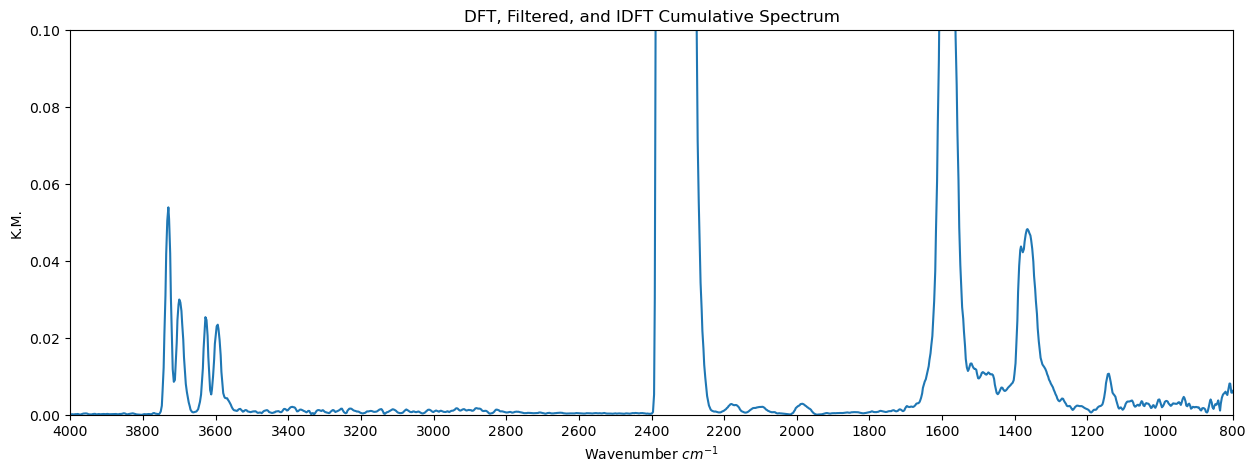

In [230]:
"""Take the sum of the absolute value of all scans."""

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(idft.columns.astype(int), idft.abs().sum())
ax.set(
    xlim = (4000, 800),
    ylim = (0, 0.1),
    xticks = np.arange(4000, 750, -200),
    #yticks = np.arange(0, 370, 20)
)
plt.title("DFT, Filtered, and IDFT Cumulative Spectrum")
plt.ylabel("K.M.")
plt.xlabel("Wavenumber $cm^{-1}$")
plt.savefig(path + "\\Transformed_filtered_spectrum.jpg")
plt.show()

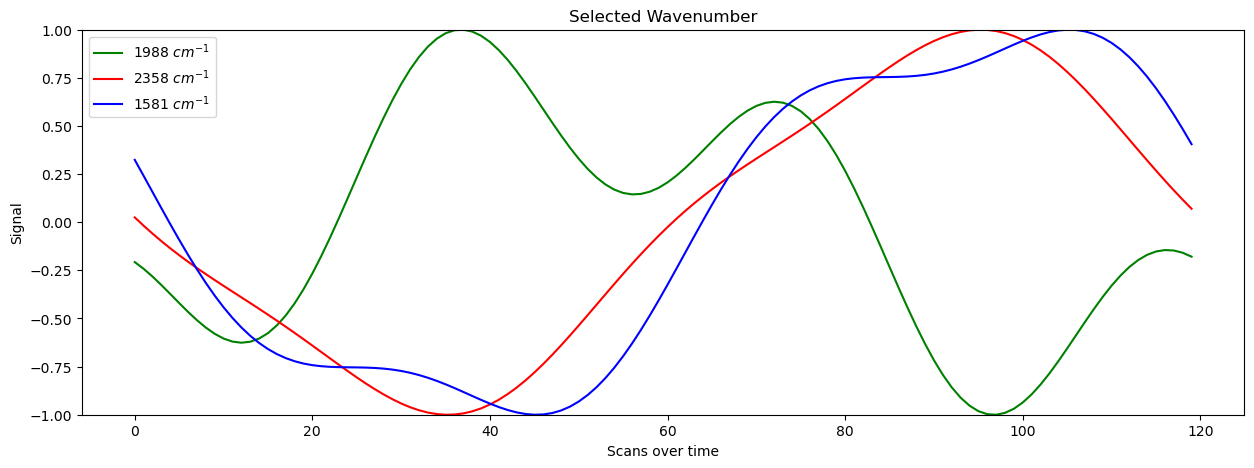

In [201]:


idft.columns = data.columns
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(idft["1988"]/np.max(idft["1988"]), "g", label = "1988 $cm^{-1}$")    # Ga-H
ax.plot(idft["2358"]/np.max(idft["2358"]), "r", label = "2358 $cm^{-1}$")    # CO2
ax.plot(idft["1581"]/np.max(idft["1581"]), "b", label = "1581 $cm^{-1}$")    # Carbonates/formate?
#ax.plot(wavenumbers, dpt.iloc[:,dim[1]-1], "r", label="Last spectrum")
plt.xlabel("Scans over time")
plt.ylabel("Signal")
plt.title("Selected Wavenumber")
ax.set(
    # xlim = (start, end),
    ylim = (-1, 1)
    #xticks = np.arange(4000, 700, -500),
    )
ax.legend(loc="best")
plt.show()

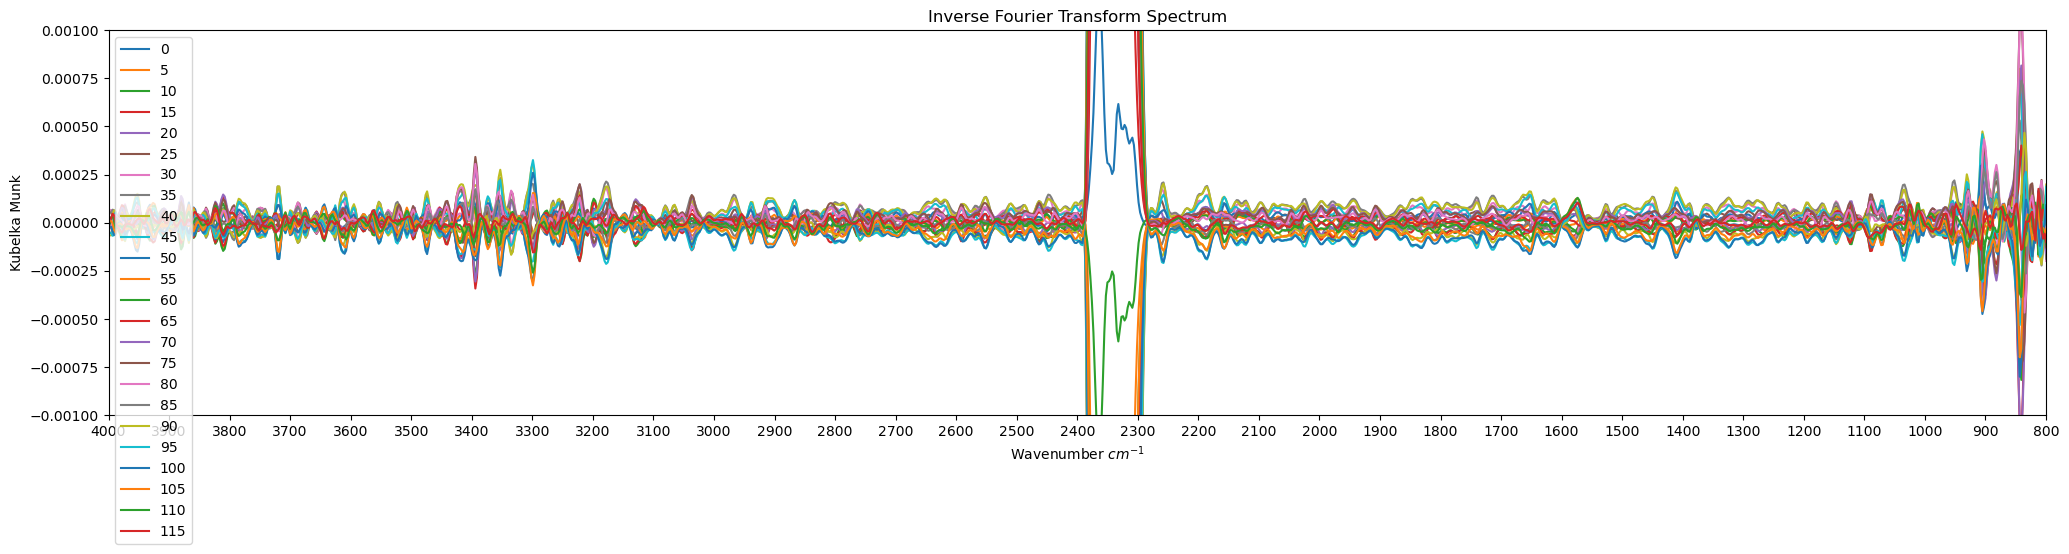

In [202]:
"""Plot real components of idft."""
idft.columns = angles.columns

inverses = np.arange(0, 120, 5)    # inverses to plot
# phase_angles = [70, 160, 250, 270, 315, 340]

y_scale = .001

fig, ax = plt.subplots(1, 1, figsize=(25, 5))
for angle in inverses:    # No more copying line by line to add angles
    ax.plot(idft.columns, idft.iloc[angle, :], label = str(angle))
ax.set(
    xlim = (4000, 800),
    ylim = (-y_scale, y_scale),
    xticks = np.arange(4000, 750, -100),
    #yticks = np.arange(0, 370, 20)
)
plt.title("Inverse Fourier Transform Spectrum")
plt.xlabel("Wavenumber $cm^{-1}$")
plt.ylabel("Kubelka Munk")
plt.legend(loc = "upper left")
plt.show()